In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import numpy.matlib

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, get_fdr_p, run_pheno_correlations, prop_bar_plot, get_fdr_p_df, get_sys_prop, update_progress

In [4]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)
    
outputdir = os.path.join(os.environ['PIPELINEDIR'], '6_results_correlations', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs
/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline/6_results_correlations/out


## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)

phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']
metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Load data

In [8]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True)
df_node_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)

(1393, 47)
(1393, 800)


## Load nispat outputs

In [9]:
z_cv = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '3_run_normative', outfile_prefix+'out_cv', 'Z.txt'), delimiter = ' ').transpose()
df_z_cv = pd.DataFrame(data = z_cv, index = df_node_train.index, columns = df_node_train.columns)

z = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '3_run_normative', outfile_prefix+'out', 'Z.txt'), delimiter = ' ').transpose()
df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns)

# concat
df_z = pd.concat((df_z_cv,df_z_test), axis = 0); print(df_z.shape)

(1393, 800)


### Regress age/sex out of psychopathology phenotypes

In [10]:
df_nuis = df.loc[:,['ageAtScan1_Years','sex_adj']]
df_nuis = sm.add_constant(df_nuis)

mdl = sm.OLS(df.loc[:,phenos], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = phenos
df.loc[:,phenos] = df.loc[:,phenos] - y_pred

# Note, regressing out age/sex from the deviations as well as the phenotypes makes no difference to the results
# # df_z
# cols = df_z.columns
# mdl = sm.OLS(df_z.loc[:,cols], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = cols
# df_z.loc[:,cols] = df_z.loc[:,cols] - y_pred

## Setup region filter
### regions with SMSE <1 in normative model

In [11]:
smse = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '3_run_normative', outfile_prefix+'out', 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

In [12]:
smse_thresh = 1
region_filter = df_smse.iloc[:,0] < smse_thresh

In [13]:
region_filter.sum()

747

## Get pheno-nispat relationships

### Regional

In [14]:
method = 'spearman'

In [15]:
assign_p = 'parametric' # 'permutation' 'parametric'
if parc_str == 'lausanne':
    assign_p = 'parametric'

In [16]:
if assign_p == 'permutation':
    nulldir = os.path.join(os.environ['NORMATIVEDIR'], 'nulls_z')
#     nulldir = os.path.join(os.environ['NORMATIVEDIR'], 'nulls_z_agesex')
    if not os.path.exists(nulldir): os.makedirs(nulldir)
    df_pheno_z = run_pheno_correlations(df.loc[:,phenos], df_z, method = method, assign_p = assign_p, nulldir = nulldir)
elif assign_p == 'parametric':
    df_pheno_z = run_pheno_correlations(df.loc[:,phenos], df_z, method = method, assign_p = assign_p)

In [17]:
# correct multiple comparisons. We do this across brain regions and phenotypes (e.g., 400*6 = 2400 tests)
df_p_corr = pd.DataFrame(index = df_pheno_z.index, columns = ['p-corr']) # output dataframe

for metric in metrics:
    p_corr = get_fdr_p(df_pheno_z.loc[:,'p'].filter(regex = metric)) # correct p-values for metric
    p_corr_tmp = pd.DataFrame(index = df_pheno_z.loc[:,'p'].filter(regex = metric).index, columns = ['p-corr'], data = p_corr) # set to dataframe with correct indices
    df_pheno_z.loc[p_corr_tmp.index, 'p-corr'] = p_corr_tmp # store using index matching

In [18]:
for pheno in phenos:
    for metric in metrics:
        print(pheno, metric, np.sum(df_pheno_z.filter(regex = metric, axis = 0).filter(regex = pheno, axis = 0).loc[:,'p-corr'] < .05) / num_parcels * 100, '% significant effects (fdr)')
    print('')

Overall_Psychopathology ct 3.25 % significant effects (fdr)
Overall_Psychopathology vol 32.0 % significant effects (fdr)

Psychosis_Positive ct 4.5 % significant effects (fdr)
Psychosis_Positive vol 18.25 % significant effects (fdr)

Psychosis_NegativeDisorg ct 0.0 % significant effects (fdr)
Psychosis_NegativeDisorg vol 6.5 % significant effects (fdr)

AnxiousMisery ct 0.0 % significant effects (fdr)
AnxiousMisery vol 2.25 % significant effects (fdr)

Externalizing ct 1.25 % significant effects (fdr)
Externalizing vol 12.75 % significant effects (fdr)

Fear ct 11.0 % significant effects (fdr)
Fear vol 22.0 % significant effects (fdr)



In [19]:
alpha = 0.05
print(alpha)

0.05


In [20]:
x = df_pheno_z['p-corr'].values < alpha
df_pheno_z['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(region_filter, 1, len(phenos))

my_bool = np.concatenate((x, y), axis = 0); region_filt = np.all(my_bool, axis = 0); df_pheno_z['sig_smse'] = region_filt

print(str(np.sum(df_pheno_z['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_smse'] == True)) + ' significant effects (fdr)')

455 significant effects (fdr)
432 significant effects (fdr)


In [21]:
for pheno in phenos:
    for metric in metrics:
        print(pheno, metric, np.sum(df_pheno_z.loc[pheno,'sig_smse'].filter(regex = metric) == True) / num_parcels * 100, '% significant effects (fdr)')
    print('')

Overall_Psychopathology ct 2.75 % significant effects (fdr)
Overall_Psychopathology vol 30.5 % significant effects (fdr)

Psychosis_Positive ct 4.25 % significant effects (fdr)
Psychosis_Positive vol 17.25 % significant effects (fdr)

Psychosis_NegativeDisorg ct 0.0 % significant effects (fdr)
Psychosis_NegativeDisorg vol 6.5 % significant effects (fdr)

AnxiousMisery ct 0.0 % significant effects (fdr)
AnxiousMisery vol 2.25 % significant effects (fdr)

Externalizing ct 1.0 % significant effects (fdr)
Externalizing vol 12.5 % significant effects (fdr)

Fear ct 9.0 % significant effects (fdr)
Fear vol 22.0 % significant effects (fdr)



In [22]:
metric = 'vol'

In [23]:
vals = np.zeros(len(phenos))

for p, pheno in enumerate(phenos):
    vals[p] = np.sum(df_pheno_z.loc[pheno,'sig_smse'].filter(regex = metric) == True) / num_parcels * 100

idx_perc_sig = np.argsort(vals)[::-1]

phenos_ordered = [phenos[i] for i in idx_perc_sig]
phenos_label_ordered = [phenos_label[i] for i in idx_perc_sig]

phenos_ordered

['Overall_Psychopathology',
 'Fear',
 'Psychosis_Positive',
 'Externalizing',
 'Psychosis_NegativeDisorg',
 'AnxiousMisery']

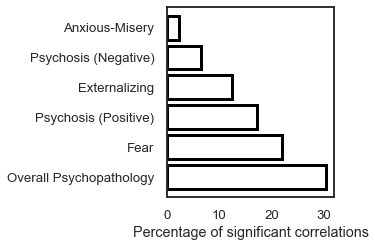

In [24]:
sns.set(style='white', context = 'talk', font_scale = 0.8)
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(3.5)

ax.barh(y = np.arange(len(phenos)), width = vals[idx_perc_sig], color = 'white', edgecolor = 'black', linewidth = 3)
ax.set_yticks(np.arange(len(phenos)))
ax.set_yticklabels(phenos_label_ordered)
ax.set_xlabel('Percentage of significant correlations')
f.savefig(outfile_prefix+'percent_sig_corrs', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Save out

In [25]:
df.to_csv(os.path.join(outputdir,outfile_prefix+'df.csv'))
df_z.to_csv(os.path.join(outputdir,outfile_prefix+'df_z.csv'))
df_pheno_z.to_csv(os.path.join(outputdir,outfile_prefix+'df_pheno_z.csv'))
region_filter.to_csv(os.path.join(outputdir,outfile_prefix+'region_filter.csv'))

## Summarise effects over Yeo networks

In [26]:
sns.set(style='white', context = 'paper', font_scale = 0.9)

Overall_Psychopathology
Thickness


/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/func.py:283: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(abs(np.round(x,2))) for x in ax.get_xticks()])


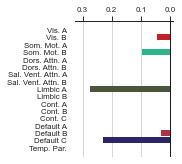

Volume


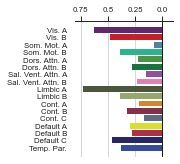

Psychosis_Positive
Thickness


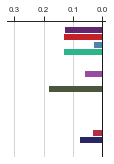

Volume


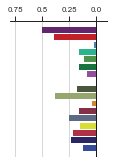

Psychosis_NegativeDisorg
Thickness


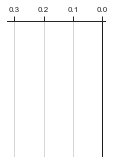

Volume


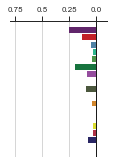

AnxiousMisery
Thickness


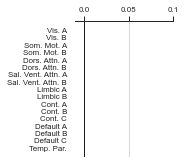

Volume


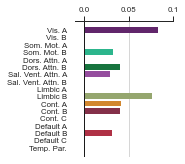

Externalizing
Thickness


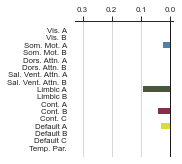

Volume


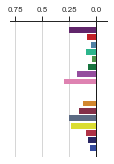

Fear
Thickness


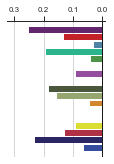

Volume


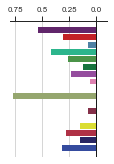

In [27]:
if parc_str == 'schaefer' and parc_scale == 400:
    for i, pheno in enumerate(phenos):
        print(pheno)
        pheno_label = phenos_label[i]
        for j, metric in enumerate(metrics):
            metric_label = metrics_label[j]
            print(metric_label)

            # Get coefficients and p-vals for phenotype effects
            coef = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
            p_vals = np.zeros(coef.shape,)
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_smse'].values; p_vals[~sig] = 1  # only plot significant coefficients
            sys_prop = get_sys_prop(coef, p_vals, yeo_idx, alpha = alpha)

            if pheno == 'AnxiousMisery': my_axlim = [-0.01,0.1]
            elif metric == 'ct': my_axlim = [-0.325,0.01]
            else: my_axlim = [-0.8,0.1]

            if pheno == 'Overall_Psychopathology' or pheno == 'AnxiousMisery': my_labels = yeo_labels
            elif metric == 'ct' and pheno == 'Externalizing': my_labels = yeo_labels
            else: my_labels = ''

            f, ax = prop_bar_plot(sys_prop, np.ones(sys_prop.shape), labels = my_labels, which_colors = 'yeo17', axlim = my_axlim, title_str = '', fig_size = [1.75,2.5])
            f.savefig(outfile_prefix+'corr_bar_' + pheno + '_' + metric + '_z.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [28]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

Notebook initialized with png backend.


In [29]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

# Brain plots

## Region filter

In [30]:
figs_to_delete = []

for metric in metrics:
    for hemi in ('lh', 'rh'):
        print(metric)
        # Plots of univariate pheno correlation
        fig_str = hemi + '_' + metric + '_region_filter'
        figs_to_delete.append('ventral_'+fig_str)
        figs_to_delete.append('med_'+fig_str)
        figs_to_delete.append('lat_'+fig_str)
        
        roi_data = region_filter.filter(regex = metric, axis = 0).astype(float).values
        roi_data[roi_data == 1] = -1000
        roi_data[roi_data == 0] = 1

        if subject_id == 'lausanne125':
            parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
        elif subject_id == 'fsaverage':
            parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

        # project subject's data to vertices
        brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', center_anchor = 1, color = 'hot')

ct
ct
vol
vol


ct


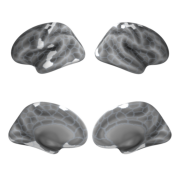

vol


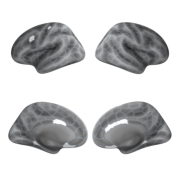

In [31]:
for metric in metrics:
    f, axes = plt.subplots(2, 2)
    f.set_figwidth(3)
    f.set_figheight(3)
    plt.subplots_adjust(wspace=0, hspace=0)

    print(metric)
    # column 0:
    fig_str = 'lh_'+metric+'_region_filter.png'
    try:
        image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
    except FileNotFoundError: axes[0,0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
    except FileNotFoundError: axes[1,0].axis('off')

    # column 1:
    fig_str = 'rh_'+metric+'_region_filter.png'
    try:
        image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
    except FileNotFoundError: axes[0,1].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
    except FileNotFoundError: axes[1,1].axis('off')

    plt.show()
    f.savefig(outfile_prefix+metric+'_region_filter.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [32]:
for file in figs_to_delete:
    try:
        os.remove(os.path.join(figdir,file+'.png'))
    except:
        print(file, 'not found')

ventral_lh_ct_region_filter not found
ventral_rh_ct_region_filter not found
ventral_lh_vol_region_filter not found
ventral_rh_vol_region_filter not found


## Figure 3

In [33]:
figs_to_delete = []

for pheno in phenos:
    for metric in metrics:
        for hemi in ('lh', 'rh'):
            print(pheno, metric)
            # Plots of univariate pheno correlation
            fig_str = hemi + '_' + pheno + '_' + metric + '_z'
            figs_to_delete.append('ventral_'+fig_str)
            figs_to_delete.append('med_'+fig_str)
            figs_to_delete.append('lat_'+fig_str)

            roi_data = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_smse']
            roi_data[~sig] = -1000

            if subject_id == 'lausanne125':
                parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            elif subject_id == 'fsaverage':
                parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            # project subject's data to vertices
            brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', center_anchor = 0.2)

Overall_Psychopathology ct
0.2
Overall_Psychopathology ct
0.2
Overall_Psychopathology vol
0.2
Overall_Psychopathology vol
0.2
Psychosis_Positive ct
0.2
Psychosis_Positive ct
0.2
Psychosis_Positive vol
0.2
Psychosis_Positive vol
0.2
Psychosis_NegativeDisorg ct
Psychosis_NegativeDisorg ct
Psychosis_NegativeDisorg vol
0.2
Psychosis_NegativeDisorg vol
0.2
AnxiousMisery ct
AnxiousMisery ct
AnxiousMisery vol
0.2
AnxiousMisery vol
0.2
Externalizing ct
Externalizing ct
0.2
Externalizing vol
0.2
Externalizing vol
0.2
Fear ct
0.2
Fear ct
0.2
Fear vol
0.2
Fear vol
0.2


Overall_Psychopathology
ct


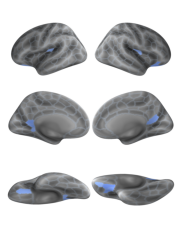

Overall_Psychopathology
vol


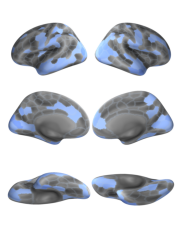

Psychosis_Positive
ct


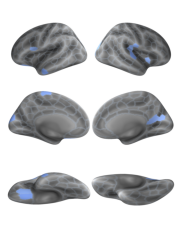

Psychosis_Positive
vol


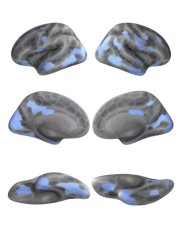

Psychosis_NegativeDisorg
ct


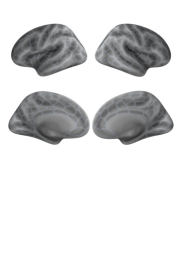

Psychosis_NegativeDisorg
vol


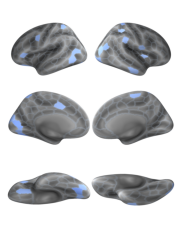

AnxiousMisery
ct


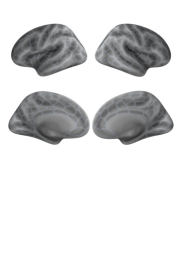

AnxiousMisery
vol


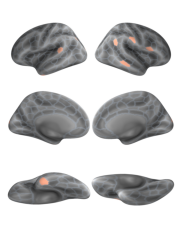

Externalizing
ct


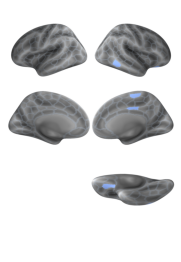

Externalizing
vol


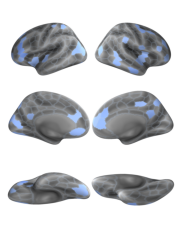

Fear
ct


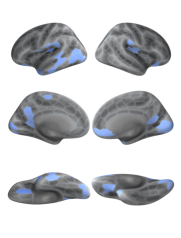

Fear
vol


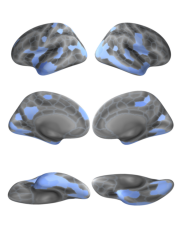

In [34]:
for pheno in phenos:
    for metric in metrics:
        f, axes = plt.subplots(3, 2)
        f.set_figwidth(3)
        f.set_figheight(5)
        plt.subplots_adjust(wspace=0, hspace=-0.465)

        print(pheno)
        print(metric)
        # column 0:
        fig_str = 'lh_'+pheno+'_'+metric+'_z.png'
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,0].imshow(image); axes[2,0].axis('off')
        except FileNotFoundError: axes[2,0].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
        except FileNotFoundError: axes[1,0].axis('off')
        try:
        #     axes[0,0].set_title('Thickness (left)')
            image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
        except FileNotFoundError: axes[0,0].axis('off')

        # column 1:
        fig_str = 'rh_'+pheno+'_'+metric+'_z.png'
        try:
        #     axes[0,1].set_title('Thickness (right)')
            image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
        except FileNotFoundError: axes[0,1].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
        except FileNotFoundError: axes[1,1].axis('off')
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,1].imshow(image); axes[2,1].axis('off')
        except FileNotFoundError: axes[2,1].axis('off')

        plt.show()
        f.savefig(outfile_prefix+metric+'_'+pheno+'_z.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [35]:
for file in figs_to_delete:
    try:
        os.remove(os.path.join(figdir,file+'.png'))
    except:
        print(file, 'not found')

ventral_lh_Psychosis_NegativeDisorg_ct_z not found
ventral_rh_Psychosis_NegativeDisorg_ct_z not found
ventral_lh_AnxiousMisery_ct_z not found
ventral_rh_AnxiousMisery_ct_z not found
ventral_lh_Externalizing_ct_z not found
